# Import Packages

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Literal, Dict

from dotenv import load_dotenv
import os

load_dotenv()

/home/nikhil/Documents/AgenticAI/PersonalAssistant/LightWeightAssistant/venv/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


True

In [2]:
# Constants
MODEL_NAME = "gemini-2.5-flash-lite"
TEMPERATURE = 0
MAX_RETRIES = 2
TIMEOUT = None
MAX_TOKENS = None

# Model Creation

In [3]:
llm = ChatGoogleGenerativeAI(
    model = MODEL_NAME,
    temperature = TEMPERATURE,
    max_tokens = MAX_TOKENS,
    timeout = TIMEOUT,
    max_retries = MAX_RETRIES
)

# Setup Tools

# Agent State

In [4]:
class AgentState(TypedDict):
    messages: List[str]
    user_query: str
    steps: List[str]
    current_step: int

# Node Creation

In [5]:
def new_state(state: AgentState, updated_state: Dict):
    new_state = {}

    new_state["messages"] = state["messages"]
    new_state["user_query"] = state["user_query"]
    new_state["steps"] = state["steps"]
    new_state["current_step"] = state["current_step"]

    for key in updated_state.keys:
        new_state[key] = updated_state[key]

    return new_state


In [6]:
# Refresh State Node
REFRESH_STATE_NODE = "Refresh State"

def refresh_state(state: AgentState):
    updated_state = {
        "user_query": "",
        "steps": [],
        "current_step": 0
    }

    return new_state(state, updated_state)

In [7]:
# Input Query Node
INPUT_QUERY_NODE = "Input Query"

def input_query(state: AgentState):
    user_input = input("User Query : ")
    
    updated_state = {
        "user_query": user_input
    }
    return new_state(state, updated_state)

In [8]:
# Instruction Breakdown Node
INSTRUCTION_BREAKDOWN_NODE = "BreakDown Instructions"

def breakdown_instructions(state: AgentState):
    instruction_breakdown_prompt = """Instruction Breakdown Prompt"""
    # call llm to breakdown instructions in parts
    # parse the steps
    new_steps = []
    
    updated_state = {
        "steps": new_steps
    }
    return new_state(state, updated_state)

In [9]:
# Steps Iterator Node
STEPS_ITERATOR_NODE = "Steps Iterator"

def iterate_steps(state: AgentState):
    previous_step = state["current_step"]

    updated_state = {
        "current_step": previous_step+1
    }
    return new_state(state, updated_state)

In [10]:
# Greet Node
GREET_NODE = "Greet"

def greet_user(state: AgentState):
    greet_user_prompt = """Greet User Prompt"""
    response = "Response from LLM"

    messages = state["messages"]
    messages.append(("ai", response))

    updated_state = {
        "messages": messages
    }
    return new_state(state, updated_state)

In [11]:
# Question Answering Node
QUESTION_ANSWERING_NODE = "Sage"

def answer_question(state: AgentState):
    answer_question_prompt = """Answer Question Prompt"""
    response = "Response from LLM"

    messages = state["messages"]
    messages.append(("ai", response))

    updated_state = {
        "messages": messages
    }
    return new_state(state, updated_state)


In [12]:
# Application Launch Node
LAUNCH_APPLICATION_NODE = "Launch Application"

def launch_application(state: AgentState):
    application_launch_prompt = """Answer Question Prompt"""
    response = "Response from LLM"

    messages = state["messages"]
    messages.append(("ai", response))

    updated_state = {
        "messages": messages
    }
    return new_state(state, updated_state)

In [13]:
# Open Website Node
OPEN_WEBSITE_NODE = "Open Website"

def open_website(state: AgentState):
    open_website_prompt = """Answer Question Prompt"""
    response = "Response from LLM"

    messages = state["messages"]
    messages.append(("ai", response))

    updated_state = {
        "messages": messages
    }
    return new_state(state, updated_state)

In [14]:
# Quit Node
QUIT_NODE = "Quit"

def quit_conversation(state: AgentState):
    return new_state(state, {})

In [15]:
# Summarize Conversation Node
SUMMARIZE_CONVERSATION_NODE = "Summarize Conversation"

def summarize_conversation(state: AgentState):
    return new_state(state, {})

In [16]:
# Next Step Checker Node
HAS_NEXT_STEP_NODE = "Has Next Step"

def shall_go_to_next_step(state: AgentState):
    return new_state(state, {})

In [17]:
workflow = StateGraph(AgentState)

## Add Nodes

In [18]:
workflow.add_node(REFRESH_STATE_NODE, refresh_state)
workflow.add_node(INPUT_QUERY_NODE, input_query)
workflow.add_node(INSTRUCTION_BREAKDOWN_NODE, breakdown_instructions)
workflow.add_node(STEPS_ITERATOR_NODE, iterate_steps)
workflow.add_node(GREET_NODE, greet_user)
workflow.add_node(QUESTION_ANSWERING_NODE, answer_question)
workflow.add_node(LAUNCH_APPLICATION_NODE, launch_application)
workflow.add_node(OPEN_WEBSITE_NODE, open_website)
workflow.add_node(QUIT_NODE, quit_conversation)
workflow.add_node(SUMMARIZE_CONVERSATION_NODE, summarize_conversation)
workflow.add_node(HAS_NEXT_STEP_NODE, shall_go_to_next_step)

## Add Edges

In [19]:
workflow.add_edge(START, REFRESH_STATE_NODE)
workflow.add_edge(REFRESH_STATE_NODE, INPUT_QUERY_NODE)
workflow.add_edge(INPUT_QUERY_NODE, INSTRUCTION_BREAKDOWN_NODE)
workflow.add_edge(INSTRUCTION_BREAKDOWN_NODE, STEPS_ITERATOR_NODE)

workflow.add_edge(GREET_NODE, HAS_NEXT_STEP_NODE)
workflow.add_edge(QUESTION_ANSWERING_NODE, HAS_NEXT_STEP_NODE)
workflow.add_edge(LAUNCH_APPLICATION_NODE, HAS_NEXT_STEP_NODE)
workflow.add_edge(OPEN_WEBSITE_NODE, HAS_NEXT_STEP_NODE)

workflow.add_edge(QUIT_NODE, SUMMARIZE_CONVERSATION_NODE)
workflow.add_edge(SUMMARIZE_CONVERSATION_NODE, END)

# Define Conditional Edges

In [20]:
def decide_next_step_node(state: AgentState) -> Literal["Greet", "Sage", "Launch Application", "Open Website", "Quit"]:
    current_step_num = state["current_step"]
    current_step = state["steps"][current_step_num]

    if current_step == "greet":
        return GREET_NODE
    elif current_step == "AnswerQuestion":
        return QUESTION_ANSWERING_NODE
    elif current_step == "LaunchApplication":
        return LAUNCH_APPLICATION_NODE
    elif current_step == "OpenWebsite":
        return OPEN_WEBSITE_NODE
    return QUIT_NODE

In [21]:
def shall_continue_iteration(state: AgentState) -> Literal["Refresh State", "Steps Iterator"]:
    current_step_num = state["current_step"]
    steps_num = len(state["steps"])

    if current_step_num >= steps_num:
        return REFRESH_STATE_NODE
    return STEPS_ITERATOR_NODE

In [22]:
# Decide on which node should handle current step
workflow.add_conditional_edges(
    STEPS_ITERATOR_NODE, 
    decide_next_step_node,
    {
        GREET_NODE: GREET_NODE,
        QUESTION_ANSWERING_NODE: QUESTION_ANSWERING_NODE,
        LAUNCH_APPLICATION_NODE: LAUNCH_APPLICATION_NODE,
        OPEN_WEBSITE_NODE: OPEN_WEBSITE_NODE,
        QUIT_NODE: QUIT_NODE
    }
)

# Decide on whether to continue step iteration or await for user input
workflow.add_conditional_edges(
    HAS_NEXT_STEP_NODE,
    shall_continue_iteration,
    {
        REFRESH_STATE_NODE: REFRESH_STATE_NODE,
        STEPS_ITERATOR_NODE: STEPS_ITERATOR_NODE
    }
)

# Compile the graph along with memory settings

In [23]:
assistant = workflow.compile()

# Draw the graph

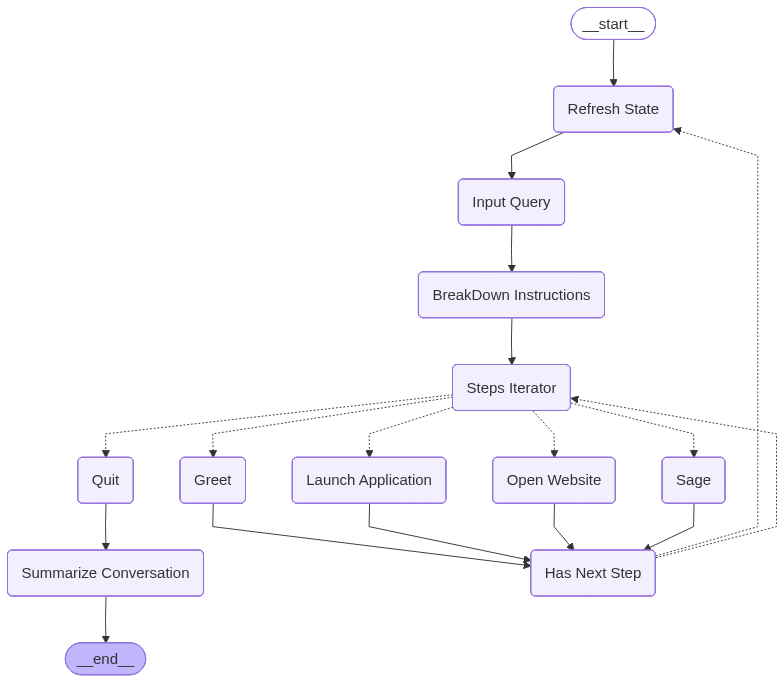

In [24]:
from IPython.display import Image

Image(
    assistant.get_graph().draw_mermaid_png()
)

# Agent Execution